Exercise Sheet 3 **Learning Dynamics in Deep Linear Networks**

__Adu Matory__ and __Lukas Braun__, November 8, 2019

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
from collections import OrderedDict
np.random.seed(1)

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

**Exercise 1: Singular Value Mode Convergence**

In [0]:
EX = np.identity(4)
EXY = np.asarray([[1., 1., 1., 1.],
                  [1., 1., 0., 0.],
                  [0., 0., 1., 1.],
                  [1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 1., 0.],
                  [1., 0., 0., 1.]])

In [0]:
# 1.1
class LinearNetwork:
    def __init__(self, sigma1, sigma2):
        self.W1 = np.random.normal(0, sigma1, (16, 4))
        self.W2 = np.random.normal(0, sigma2, (7, 16))
    
    def forward(self, x):
        return self.W2@self.W1@x
    
    def backward(self, EX, EXY, tau, delta_t):
        svds = []
        for i in range(int(1/delta_t)):
            delta_W1 = (1/tau)*self.W2.T@(EXY - self.W2@self.W1@EX)
            delta_W2 = (1/tau)*(EXY - self.W2@self.W1@EX)@self.W1.T
            self.W1 += delta_W1*delta_t
            self.W2 += delta_W2*delta_t
            svds.append(np.linalg.svd(self.W2@self.W1)[1])
        return svds


class ShallowNetwork:
    def __init__(self, sigma):
        self.W = np.random.normal(0, sigma, (7, 4))
    
    def forward(self, x):
        return self.W@x
    
    def backward(self, EX, EXY, tau, delta_t):
        svds = []
        for i in range(int(1/delta_t)):
            delta_W = (1/tau)*(EXY-self.W@EX)
            self.W += delta_W*delta_t
            svds.append(np.linalg.svd(self.W)[1])
        return svds

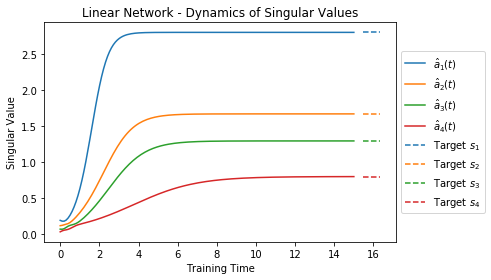

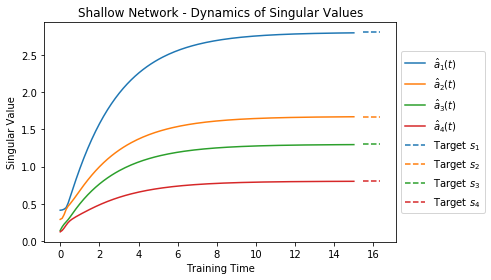

In [42]:
# 1.2
targets = np.linalg.svd(EXY)[1]

sigma = np.sqrt(0.01)
tau = 1/0.4
T = 15
delta_t = 0.1
time = np.linspace(0, T, int(T/delta_t))

# Linear Network
linear_network = LinearNetwork(sigma, sigma)
all_svds = []
for t in range(T):
    all_svds.append(linear_network.backward(EX, EXY, tau, delta_t))
all_svds = np.asarray(all_svds).reshape(-1, 4)

fig, ax = plt.subplots(figsize=(6, 4))
for i, svd in enumerate(all_svds.T):
    ax.plot(time, svd, label="$\\hat{a}_"+f"{i+1}(t)$")
for i, target in enumerate(targets):
    ax.hlines(target, np.max(time)*1.03, np.max(time)*1.09,
              color=colors[i], linestyle="--", label=f"Target $s_{i+1}$")

ax.set_title("Linear Network - Dynamics of Singular Values")
ax.set_xlabel("Training Time")
ax.set_ylabel("Singular Value")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()


# Shallow Network
shallow_network = ShallowNetwork(sigma)
all_svds = []
for t in range(T):
    all_svds.append(shallow_network.backward(EX, EXY, tau, delta_t))
all_svds = np.asarray(all_svds).reshape(-1, 4)


fig, ax = plt.subplots(figsize=(6, 4))
for i, svd in enumerate(all_svds.T):
    ax.plot(time, svd, label="$\\hat{a}_"+f"{i+1}(t)$")
for i, target in enumerate(targets):
    ax.hlines(target, np.max(time)*1.03, np.max(time)*1.09,
              color=colors[i], linestyle="--", label=f"Target $s_{i+1}$")

ax.set_title("Shallow Network - Dynamics of Singular Values")
ax.set_xlabel("Training Time")
ax.set_ylabel("Singular Value")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()


**What can you observe?**


We observe sharp periods of rapid improvement followed by plateaus, as the singular value modes a_hat(t) converge to the singular values s. The convergence is much faster for all a_hat in the single-hidden layer network than for those in the shallow network.

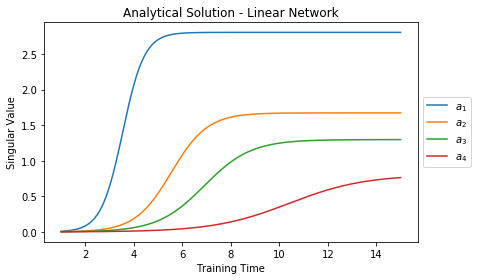

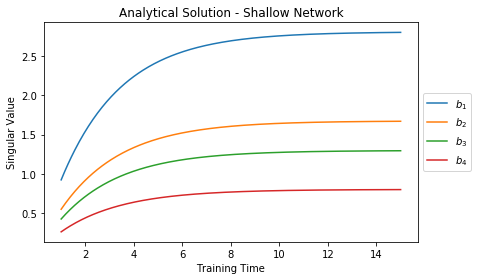

In [41]:
# 1.3
def singular_value_dynamics_linear(time, a_zero, s_alpha, tau):
    out = np.zeros_like(time)
    for i, t in enumerate(time):
        nom = s_alpha*np.exp(2*s_alpha*t/tau)
        denom = np.exp(2*s_alpha*t/tau)- 1 + s_alpha/a_zero
        out[i] = nom/denom
    return out

def singular_value_dynamics_shallow(time, b_zero, s_alpha, tau):
    out = np.zeros_like(time)
    for i, t in enumerate(time):
        out[i] = s_alpha*(1-np.exp(-t/tau))+b_zero*np.exp(-t/tau)
    return out

singular_values = np.linalg.svd(EXY)[1]
time = np.linspace(1, 150/10, 300)
a_zero = b_zero = 0.001
tau = 1/0.4

fig, ax = plt.subplots()
for i, s_alpha in enumerate(singular_values):
    ax.plot(time, singular_value_dynamics_linear(time, a_zero, s_alpha, tau), label=f"$a_{i+1}$")
    ax.set_title("Analytical Solution - Linear Network")
    ax.set_xlabel("Training Time")
    ax.set_ylabel("Singular Value")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()


fig, ax = plt.subplots()
for i, s_alpha in enumerate(singular_values):
    ax.plot(time, singular_value_dynamics_shallow(time, a_zero, s_alpha, tau),  label=f"$b_{i+1}$")
    ax.set_title("Analytical Solution - Shallow Network")
    ax.set_xlabel("Training Time")
    ax.set_ylabel("Singular Value")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

**How well do theory and simulation align?**

Simulation and theory align better for the shallow than the hidden-layer network. We still see more nonlinearity and faster learning rates for the hidden-layer vs. the shallow network. 

Between the analytical and Euler-integrated hidden-layer networks, however, we see a larger initial delay in learning, before the exponential increase in learning present in the dynamics of both implementation of the network.

The dynamics of the two implementations of the shallow network are much more aligned, and learning occurs in more similar rates.

**Exercise 2: Deeper (Non-)Linear Networks with AutoDiff**

In [0]:
class DiffuseTreeSampler():
    def __init__(self, target_dim, tree_depth, branching_factor, sample_epsilon):
        self.target_dim = target_dim
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_target(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        target_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(target_tree[-1], self.branching_factor)
            target_tree.append(next_layer*switch)
        return target_tree[-1]
    
    def sample_data(self):
        """
        Each target dimension diffuses independently of the others!
        """
        targets = []
        for tar in range(self.target_dim):
            target_temp = self.sample_target()
            targets.append(target_temp)
        
        targets_out = np.array(targets).T
        features_out = np.diag(np.ones(self.num_examples))
        return targets_out, features_out

In [0]:
# 2.1
class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, relu=False):
        super().__init__()
        units = [input_dim] + hidden_units + [output_dim]
        layers = OrderedDict()
        for i, (in_units, out_units) in enumerate(zip(units, units[1:])):
            layers[f"layer_{i}"] = torch.nn.Linear(in_units, out_units, bias=False)
            if relu and i < len(units)-2:
                layers[f"activation_{i}"] = torch.nn.ReLU()
        self.model = torch.nn.Sequential(layers)
    
    def forward(self, x):
        return self.model(x.float())

In [0]:
# 2.2
def train(model, criterion, optimizer, epochs_n, features, targets):
    losses = []
    singular_values = []
    samples_n = targets.shape[0]
    
    for epoch in range(epochs_n):
        # Shuffle
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        features = features[random_indices]
        targets = targets[random_indices]
        
        epoch_loss = 0
        for t in range(samples_n):
            feature = torch.tensor(features[t]).float()
            target = torch.tensor(targets[t]).float()
            
            prediction = model.forward(feature)
            
            optimizer.zero_grad()
            loss = criterion(prediction, target)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        losses.append(epoch_loss/samples_n)
        y_hat_full = model.forward(torch.tensor(features)).detach().numpy()
        s = np.linalg.svd(y_hat_full.T, full_matrices=True)[1]
        singular_values.append(s)
    return np.asarray(losses), np.asarray(singular_values)

In [0]:
# 2.3
tree = DiffuseTreeSampler(target_dim=100, tree_depth=3, branching_factor=4, sample_epsilon=0.5)
targets, features = tree.sample_data()

EX = features.T@features
assert (EX == np.identity(EX.shape[1])).all()
EXY = targets.T@features
s_targets = np.linalg.svd(EXY, full_matrices=True)[1]

net = Model(64, [64, 128, 128], 100)
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
criterion = torch.nn.MSELoss()
epochs_n = 1000

losses, singular_values = train(net, criterion, optimizer, epochs_n, features, targets)

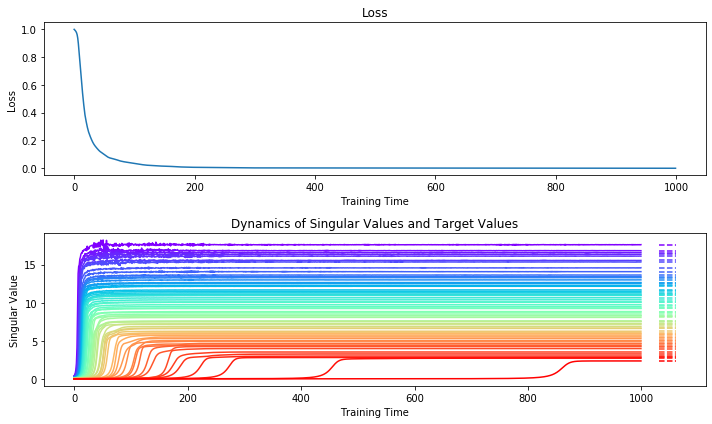

In [31]:
colors = cm.rainbow(np.linspace(0, 1, 64))
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(losses)
axs[0].set_title("Loss")
axs[0].set_xlabel("Training Time")
axs[0].set_ylabel("Loss")
for i, singular_value in enumerate(singular_values.T):
    axs[1].plot(singular_value, c=colors[i])
for i, s_target in enumerate(s_targets):
    axs[1].hlines(s_target, losses.shape[0]*1.03, losses.shape[0]*1.06,
                  color=colors[i], linestyle="--")
axs[1].set_title("Dynamics of Singular Values and Target Values")
axs[1].set_xlabel("Training Time")
axs[1].set_ylabel("Singular Value")
fig.tight_layout()

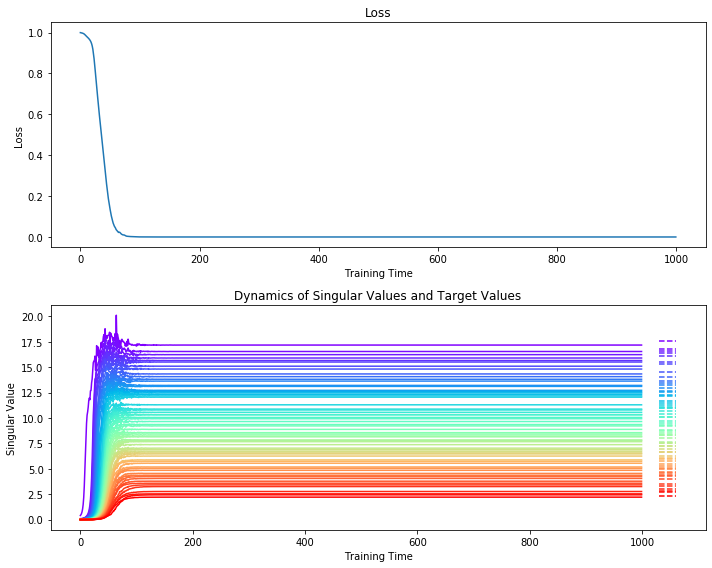

In [32]:
# 2.4
tree = DiffuseTreeSampler(target_dim=100, tree_depth=3, branching_factor=4, sample_epsilon=0.5)
targets, features = tree.sample_data()

net = Model(64, [64, 128, 128], 100, True)
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
criterion = torch.nn.MSELoss()
epochs_n = 1000

losses, singular_values = train(net, criterion, optimizer, epochs_n, features, targets)

colors = cm.rainbow(np.linspace(0, 1, 64))
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(losses)
axs[0].set_title("Loss")
axs[0].set_xlabel("Training Time")
axs[0].set_ylabel("Loss")
for i, singular_value in enumerate(singular_values.T):
    axs[1].plot(singular_value, c=colors[i])
for i, s_target in enumerate(s_targets):
    axs[1].hlines(s_target, losses.shape[0]*1.03, losses.shape[0]*1.06,
                  color=colors[i], linestyle="--")
axs[1].set_title("Dynamics of Singular Values and Target Values")
axs[1].set_xlabel("Training Time")
axs[1].set_ylabel("Singular Value")
fig.tight_layout()

**Do the results hold up for both deep linear and non-linear networks?** **Which singular values converge first?**

The singular values in the non-linear network converge much faster, with each singular value converging around the same time. There is greater variability in the time of convergence between singular values in the deep linear network. 

Both experience exponential learning, but in the deep linear network, the exponential learning is staggered across the singular values.